In [1]:
!pip install medmnist


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, f1_score
import medmnist
from medmnist import INFO, Evaluator
import matplotlib.pyplot as plt
from DNN import DNN
from fit import fit
from fit import evaluate_nn
from CNN import CNN

In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


# We work on the 2D dataset with size 28x28

In [4]:
data_flag = 'bloodmnist'
download = True
BATCH_SIZE = 128

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [5]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


In [6]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset BloodMNIST of size 28 (bloodmnist)
    Number of datapoints: 11959
    Root location: C:\Users\PC\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
    Number of samples: {'train': 11959, 'val': 1712, 'test': 3421}
    Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.
    License

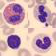

In [7]:
# visualization

train_dataset.montage(length=2)



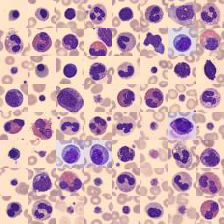

In [8]:

train_dataset.montage(length=8)

In [9]:
#Access a single image / label
image, label = train_dataset[2]  # image is a tensor , label is an  int
print("Shape da imagem:", image.shape)
print("Classe:", label)

# Convert to NumPy array
image_array = image.numpy()
print("Size:", image_array.shape )

#Access a subset of images
img = train_dataset[1][0].numpy   # image
lab = train_dataset[1][1]   # label
start_idx = 10
end_idx = 20  # exclusive
images_array = np.stack([train_dataset[i][0].numpy() for i in range(start_idx, end_idx)])
labels_array = np.array([train_dataset[i][1] for i in range(start_idx, end_idx)])

print("Size:", images_array.shape )
print(labels_array)

Shape da imagem: torch.Size([3, 28, 28])
Classe: [6]
Size: (3, 28, 28)
Size: (10, 3, 28, 28)
[[1]
 [1]
 [6]
 [7]
 [6]
 [3]
 [7]
 [2]
 [6]
 [1]]


In [10]:
def plot_graph(acc_train, title,n_epochs):
    epochs = range(1, n_epochs + 1)

    plt.figure(figsize=(8,5))
    plt.plot(epochs, acc_train, label='Train Accuracy', marker='o', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_class_accuracy(conf_mat, class_names=None, title='Correct vs Total per Class'):
    correct_per_class = np.diag(conf_mat)       # acertos por classe
    total_per_class = conf_mat.sum(axis=1)      # total de amostras por classe
    
    if class_names is None:
        class_names = [f'Class {i}' for i in range(len(correct_per_class))]
    
    x = np.arange(len(class_names))  
    width = 0.35  

    plt.figure(figsize=(10,6))
    plt.bar(x - width/2, total_per_class, width, label='Total', color='lightgray')
    plt.bar(x + width/2, correct_per_class, width, label='Correct', color='skyblue')
    
    plt.xlabel('Classes')
    plt.ylabel('Number of samples')
    plt.title(title)
    plt.xticks(x, class_names)
    plt.legend()
    plt.grid(axis='y')
    plt.show()

def plot_losses(losses, title='Loss over Epochs'):
    epochs = range(1, len(losses) + 1)
    plt.figure(figsize=(8,5))
    plt.plot(epochs, losses, label='Training Loss', marker='o', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()


Training Model: MLNN, Loss: CrossEntropy, Optimizer: SGD


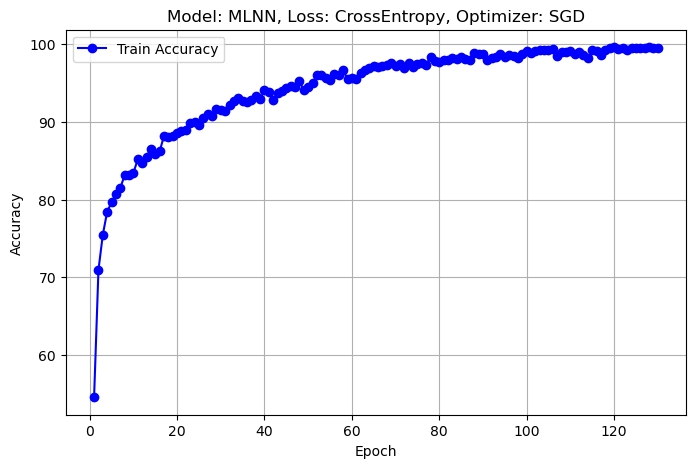

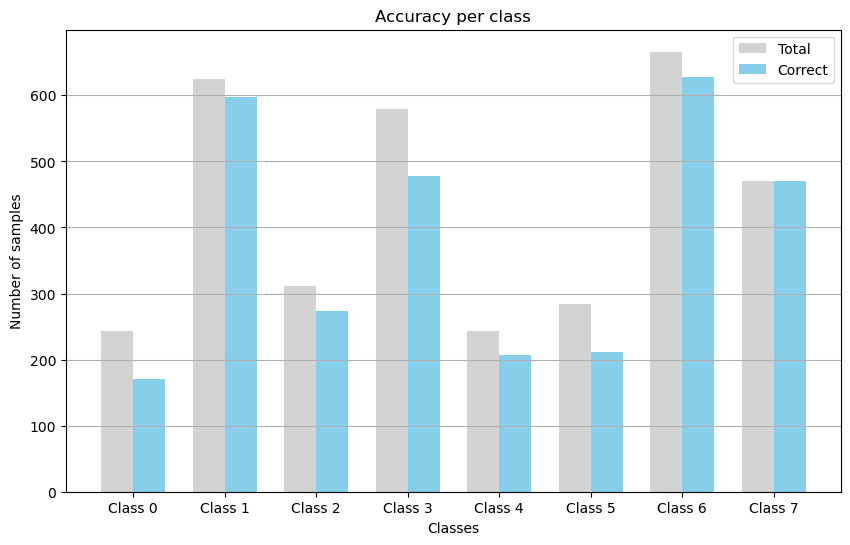

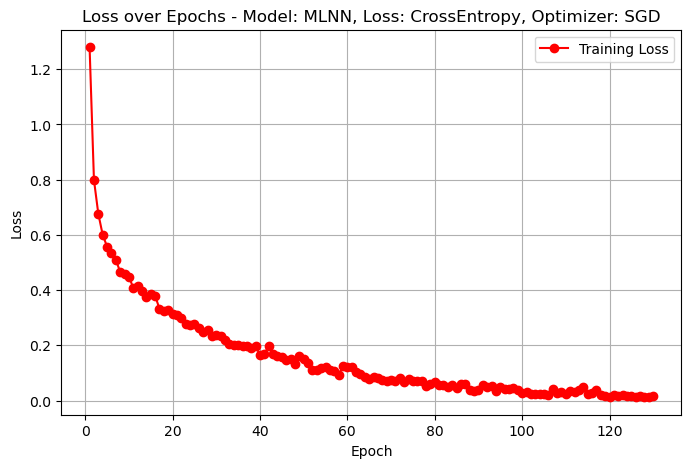

Training Model: MLNN, Loss: CrossEntropy, Optimizer: Adam


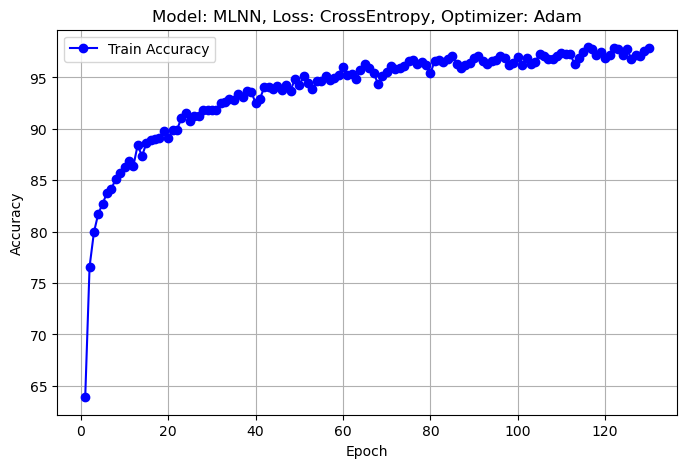

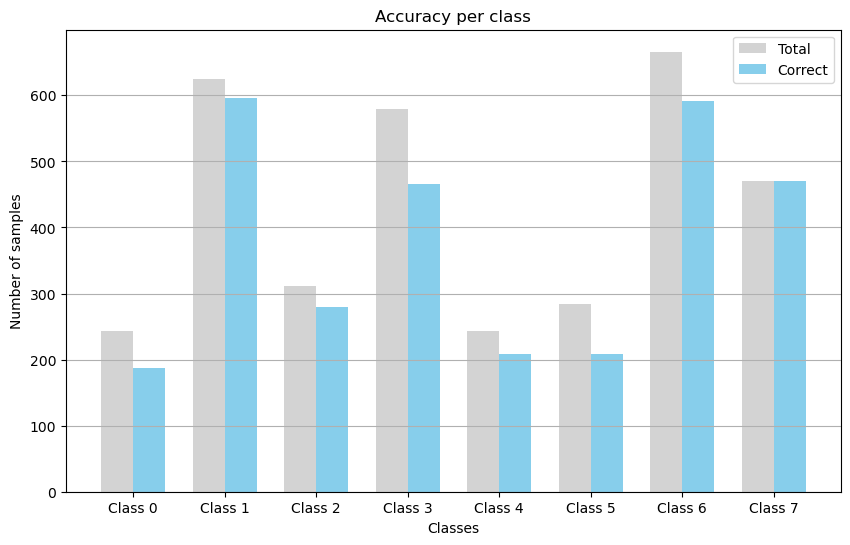

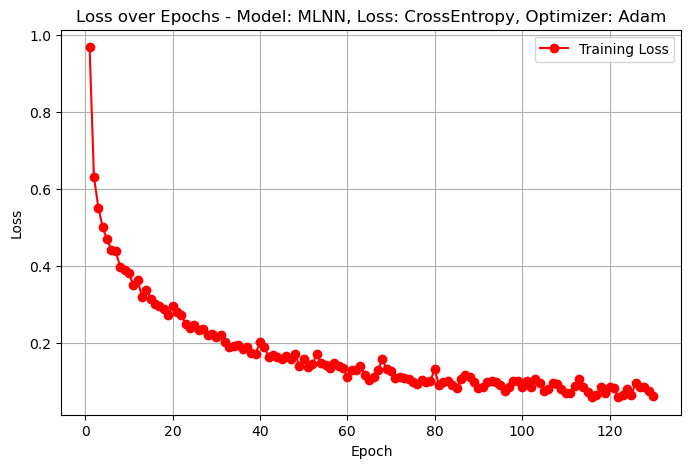

Training Model: MLNN, Loss: NLL, Optimizer: SGD


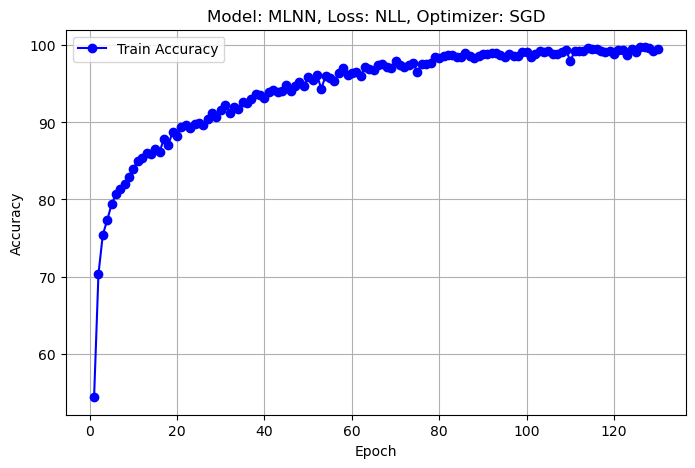

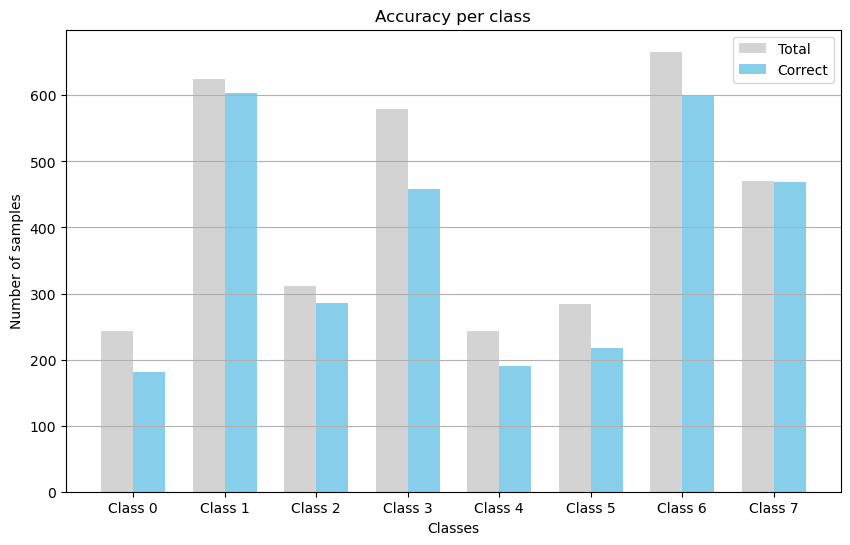

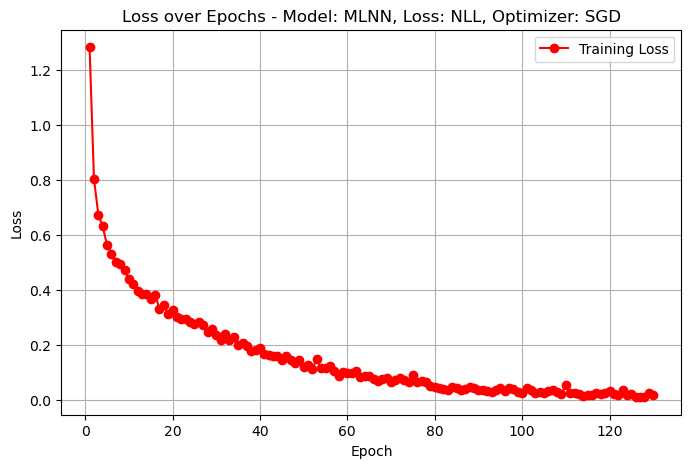

Training Model: MLNN, Loss: NLL, Optimizer: Adam


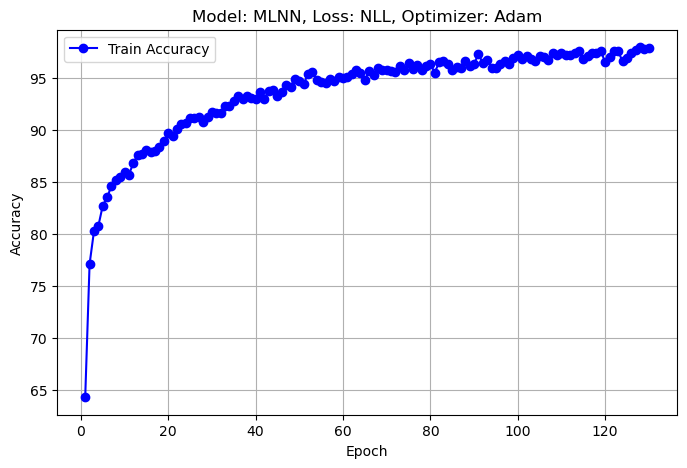

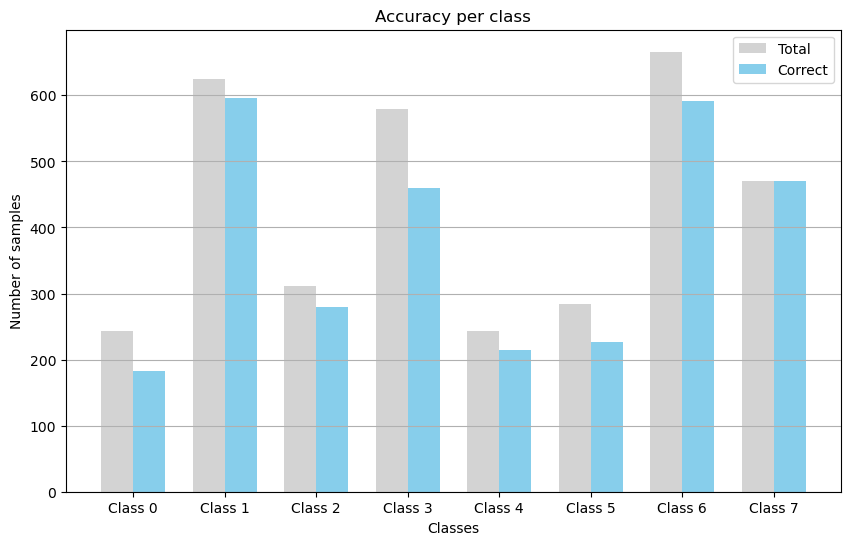

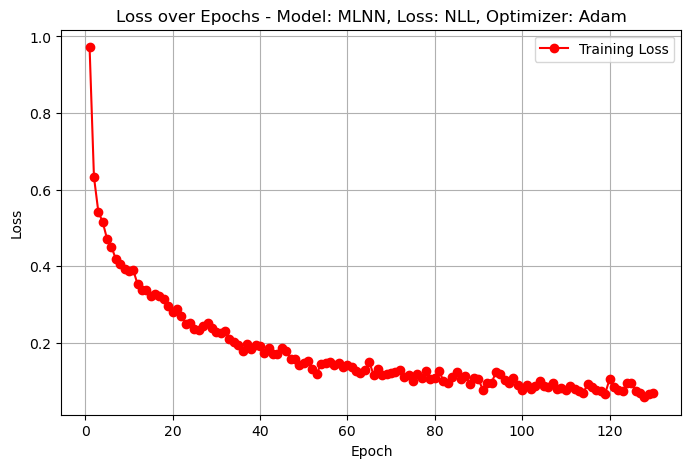

Training Model: CNN, Loss: CrossEntropy, Optimizer: SGD


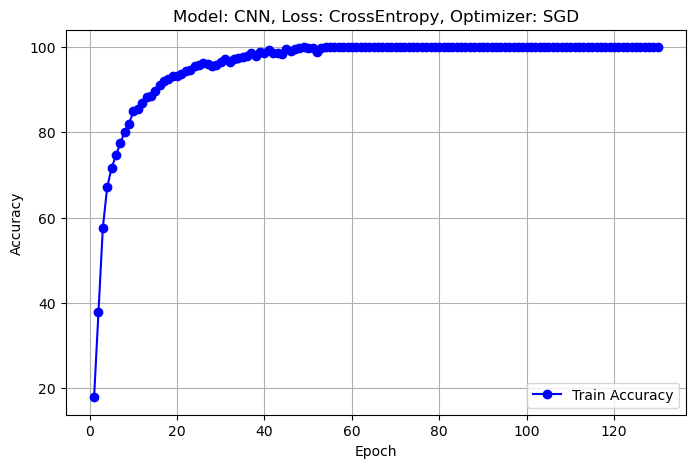

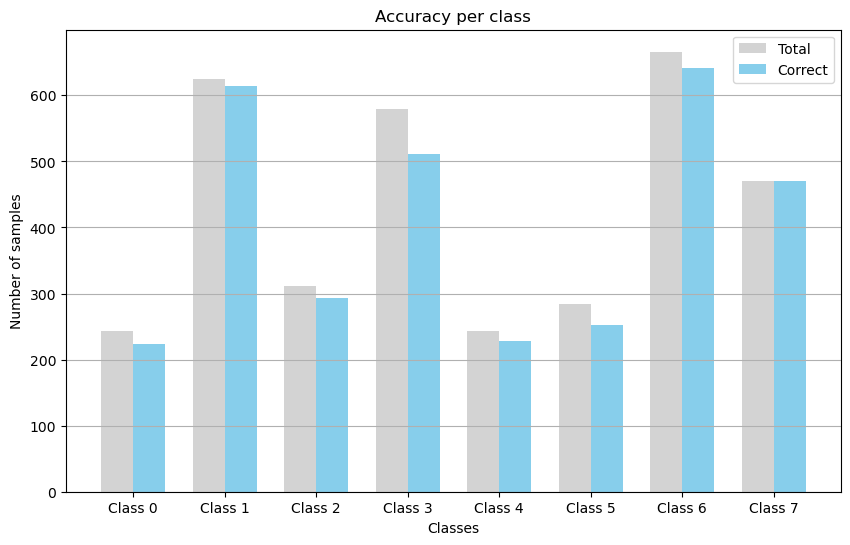

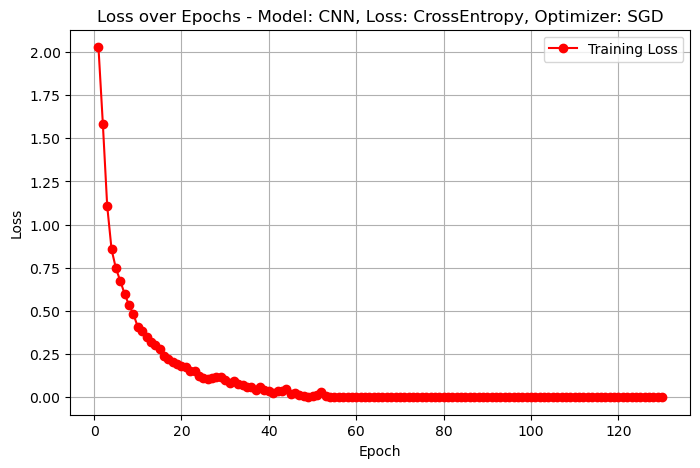

Training Model: CNN, Loss: CrossEntropy, Optimizer: Adam


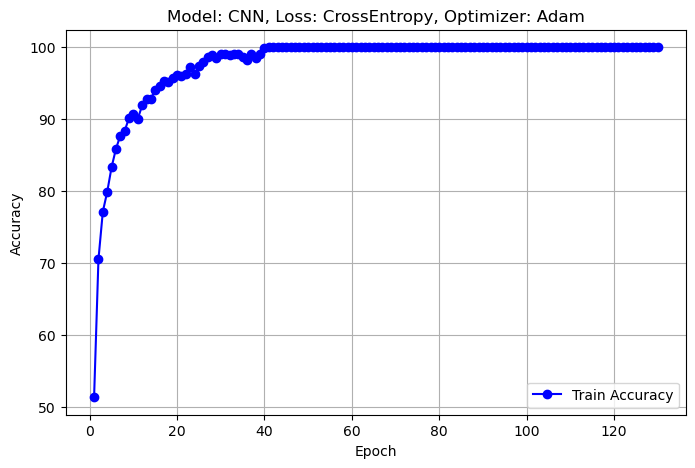

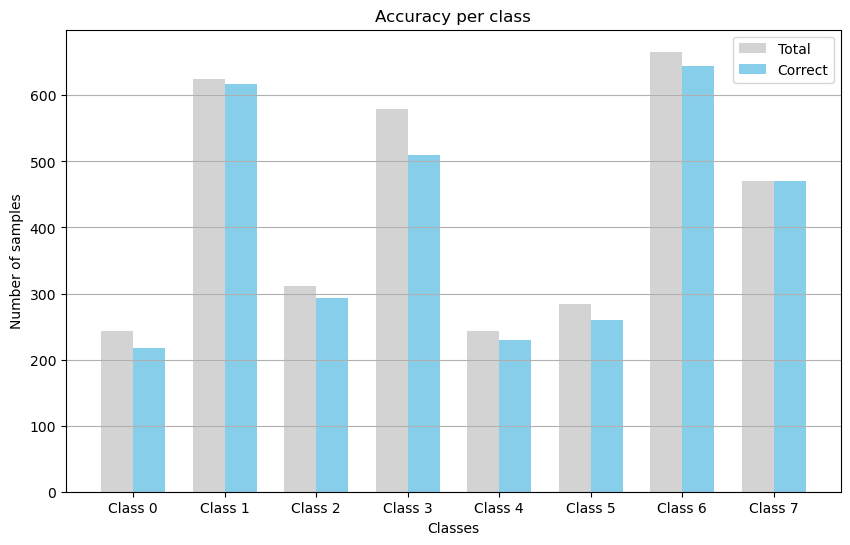

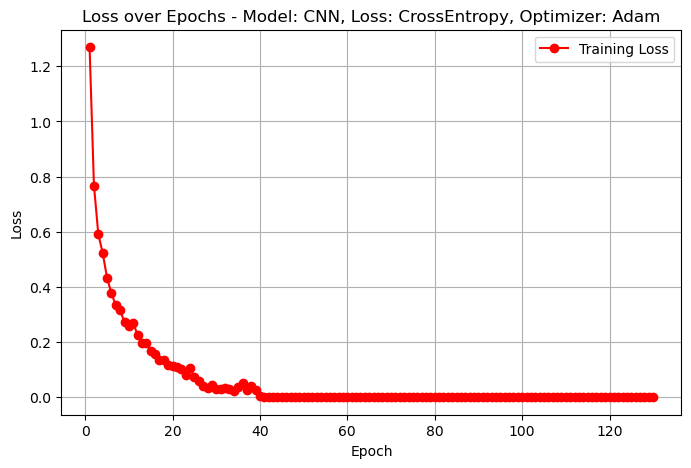

Training Model: CNN, Loss: NLL, Optimizer: SGD


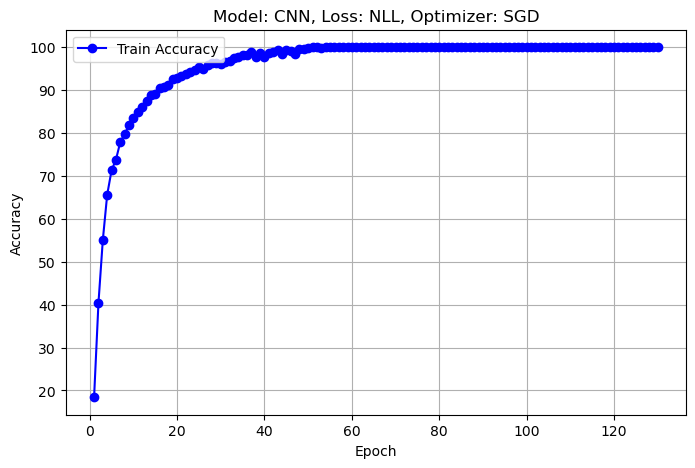

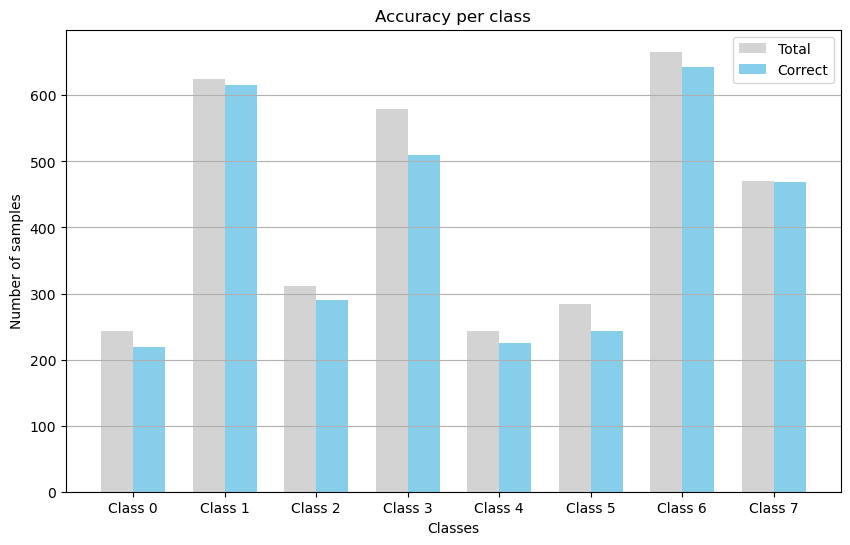

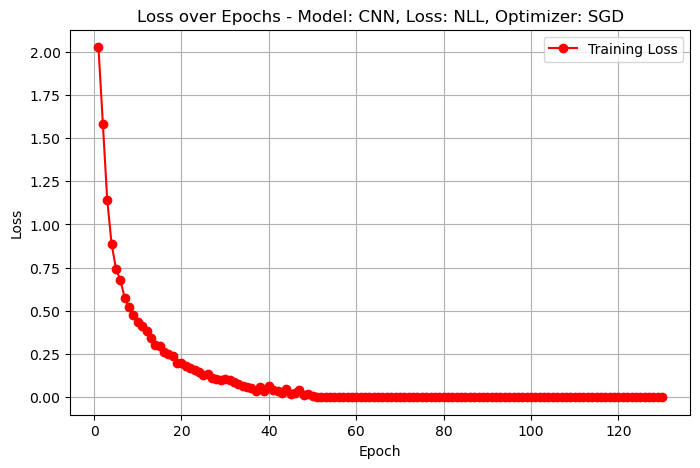

Training Model: CNN, Loss: NLL, Optimizer: Adam


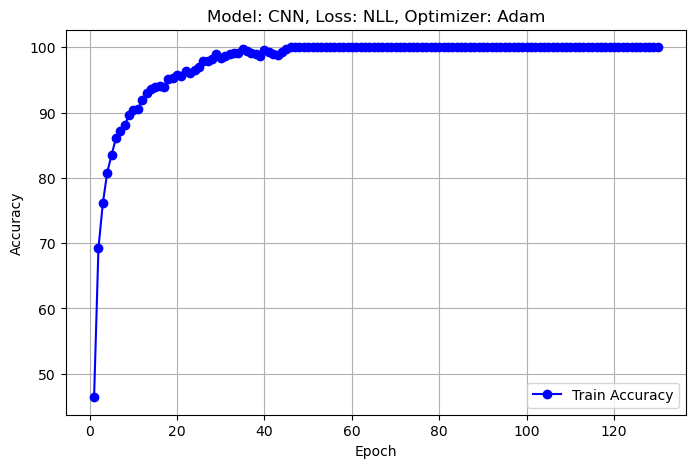

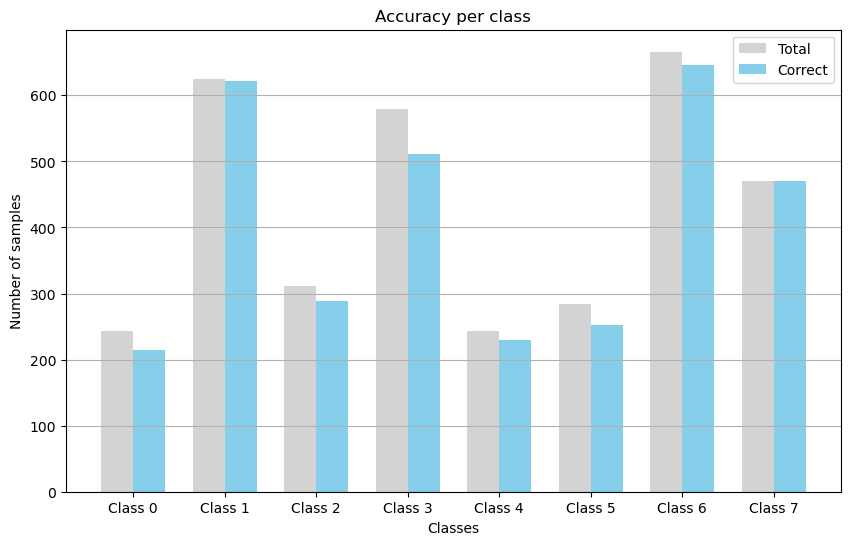

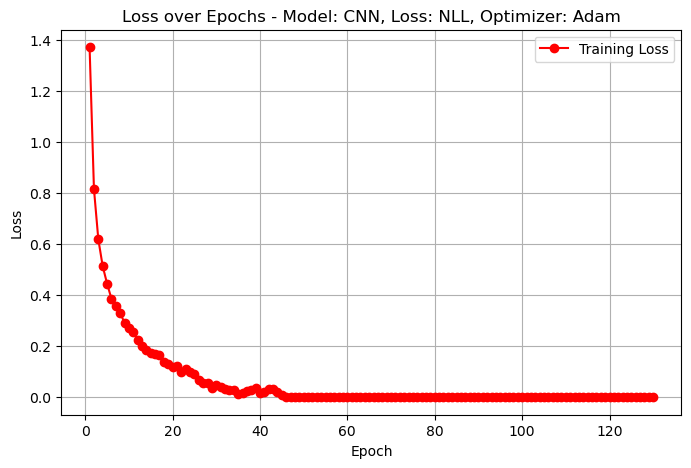

In [11]:
num_inputs = 28 * 28 * 3
num_classes = 8
hidden_layer_sizes = ((num_inputs+num_classes)//2,) * 2 # 2 hidden layer
n_epochs = 130

models = ["MLNN","CNN"]

losses = {
    "CrossEntropy": nn.CrossEntropyLoss(),
    "NLL": nn.NLLLoss() 
}

optimizers = {
    "SGD": lambda params: optim.SGD(params, lr=0.01, momentum=0.9),
    "Adam": lambda params: optim.Adam(params, lr=0.001)
}

with open("results.txt", "w") as f:
    for model_name in models:
        for loss_name, criterion in losses.items():
            for opt_name, opt_fn in optimizers.items():
                if model_name == "MLNN":
                    model = DNN(input_size=num_inputs, hidden_sizes=hidden_layer_sizes, num_classes=num_classes)
                    flatten = True
                else:
                    model = CNN(input_channels=3, num_classes=num_classes)
                    flatten = False
                    
                use_nll = (loss_name=="NLL")
                optimizer = opt_fn(model.parameters())
                
                print(f"Training Model: {model_name}, Loss: {loss_name}, Optimizer: {opt_name}")
                
                trained_model, losses_values, acc_train = fit(train_loader, model, criterion, optimizer, n_epochs=n_epochs, to_device=True, flatten=flatten, use_nll=use_nll)
                
                f.write(f"Modelo: {model_name}, Loss: {loss_name}, Optimizer: {opt_name}\n")
                f.write("Resultados:\n")
                acc_evaluate, cm, f1 = evaluate_nn(trained_model, test_loader, flatten=flatten, file=f)
                f.write("\n" + "-"*50 + "\n")
                plot_graph(acc_train, f"Model: {model_name}, Loss: {loss_name}, Optimizer: {opt_name}", n_epochs)
                plot_class_accuracy(cm, title='Accuracy per class')
                plot_losses(losses_values, title=f"Loss over Epochs - Model: {model_name}, Loss: {loss_name}, Optimizer: {opt_name}")
                
                
